In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

In [2]:
tickers=['ZGLD.SW','MSFT','REIT','TIP']
weights=np.array([0.25,0.25,0.25,0.25])
risk_free_rate=0.02

In [3]:
end_date=datetime.today().date()
print(end_date)

2024-11-15


In [4]:
start_date=end_date-timedelta(days=5*365)
print(start_date)

2019-11-17


In [5]:
adj_close_df=pd.DataFrame()
for ticker in tickers:
    data=yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker]=data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
adj_close_df

,ZGLD.SW,MSFT,REIT,TIP
Date,,,,
2019-11-18 00:00:00+00:00,443.500000,143.597229,NaN,97.964989
2019-11-19 00:00:00+00:00,444.549988,143.644958,NaN,98.142265
2019-11-20 00:00:00+00:00,444.000000,143.395813,NaN,98.522102
2019-11-21 00:00:00+00:00,443.450012,143.261612,NaN,98.302658
2019-11-22 00:00:00+00:00,444.750000,143.367081,NaN,98.336411
...,...,...,...,...
2024-11-08 00:00:00+00:00,698.799988,422.540009,29.000000,108.570000
2024-11-11 00:00:00+00:00,684.900024,418.010010,28.959999,108.209999
2024-11-12 00:00:00+00:00,682.500000,423.029999,28.580000,107.639999


In [7]:
adj_close_df.dropna(inplace=True)

In [8]:
adj_close_df

,ZGLD.SW,MSFT,REIT,TIP
Date,,,,
2021-02-26 00:00:00+00:00,473.700012,225.590714,21.420008,107.701447
2021-03-01 00:00:00+00:00,480.549988,230.017487,21.300283,107.341942
2021-03-02 00:00:00+00:00,478.500000,227.037186,21.163948,107.778473
2021-03-03 00:00:00+00:00,478.299988,220.911530,21.058205,107.504555
2021-03-04 00:00:00+00:00,480.700012,220.105789,20.795149,107.093742
...,...,...,...,...
2024-11-08 00:00:00+00:00,698.799988,422.540009,29.000000,108.570000
2024-11-11 00:00:00+00:00,684.900024,418.010010,28.959999,108.209999
2024-11-12 00:00:00+00:00,682.500000,423.029999,28.580000,107.639999


In [9]:
#final/initial of an asset can be positive only, if the asset price increases then final/initial>1 otherwise <1, log returns give log(final/initial) 
#which is positive if final/initial >1 and negatice if finaL/initial <1
log_returns=np.log(adj_close_df/adj_close_df.shift(1))

In [10]:
log_returns.dropna(inplace=True)

In [11]:
log_returns

,ZGLD.SW,MSFT,REIT,TIP
Date,,,,
2021-03-01 00:00:00+00:00,0.014357,0.019433,-0.005605,-0.003344
2021-03-02 00:00:00+00:00,-0.004275,-0.013042,-0.006421,0.004058
2021-03-03 00:00:00+00:00,-0.000418,-0.027352,-0.005009,-0.002545
2021-03-04 00:00:00+00:00,0.005005,-0.003654,-0.012571,-0.003829
2021-03-05 00:00:00+00:00,-0.005110,0.021252,0.008579,0.001038
...,...,...,...,...
2024-11-08 00:00:00+00:00,-0.000143,-0.006816,0.017041,0.002767
2024-11-11 00:00:00+00:00,-0.020092,-0.010779,-0.001380,-0.003321
2024-11-12 00:00:00+00:00,-0.003510,0.011938,-0.013208,-0.005281


In [12]:
cov_matrix=log_returns.cov()*252
print(cov_matrix)

          ZGLD.SW      MSFT      REIT       TIP
ZGLD.SW  0.015846  0.000786  0.001168  0.001768
MSFT     0.000786  0.071355  0.021962  0.003131
REIT     0.001168  0.021962  0.038388  0.004055
TIP      0.001768  0.003131  0.004055  0.004708


In [13]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [14]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

In [15]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [16]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [17]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.3) for _ in range(len(tickers))]  # Each weight between 0 and 0.4
initial_weights = np.array([1/len(tickers)] * len(tickers))  # Initial guess: assigns equal weight to all the tickers

In [18]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [19]:
optimal_weights=optimized_results.x
optimal_weights

array([0.3       , 0.3       , 0.25337493, 0.14662507])

In [20]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

Optimal Weights:
ZGLD.SW: 0.3000
MSFT: 0.3000
REIT: 0.2534
TIP: 0.1466


In [21]:
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Expected Annual Return: 0.1019
Expected Volatility: 0.1217
Sharpe Ratio: 0.6731


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Expected Annual Return: 0.0878
Expected Volatility: 0.1107
Sharpe Ratio: 0.6127


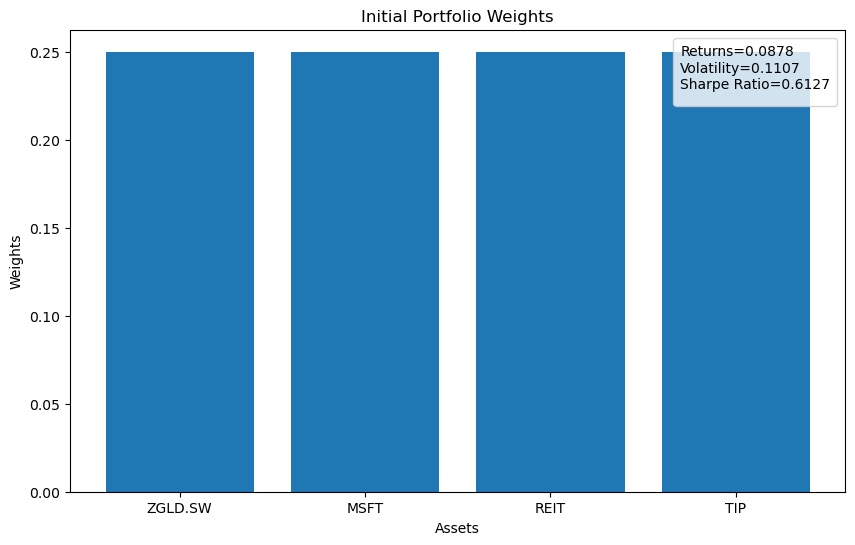

In [22]:
portfolio_return = expected_return(initial_weights, log_returns)
portfolio_volatility = standard_deviation(initial_weights, cov_matrix)
sharpe_ratio = sharpe_ratio(initial_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {portfolio_return:.4f}")
print(f"Expected Volatility: {portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
plt.figure(figsize=(10, 6))
plt.bar(tickers, weights)

plt.xlabel('Assets')
plt.ylabel('Weights')
plt.title('Initial Portfolio Weights')
plt.legend(loc='upper right', fontsize='large', title=f'Returns={portfolio_return:.4f}\n\
Volatility={portfolio_volatility:.4f}\n\
Sharpe Ratio={sharpe_ratio:.4f}', title_fontsize='medium')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


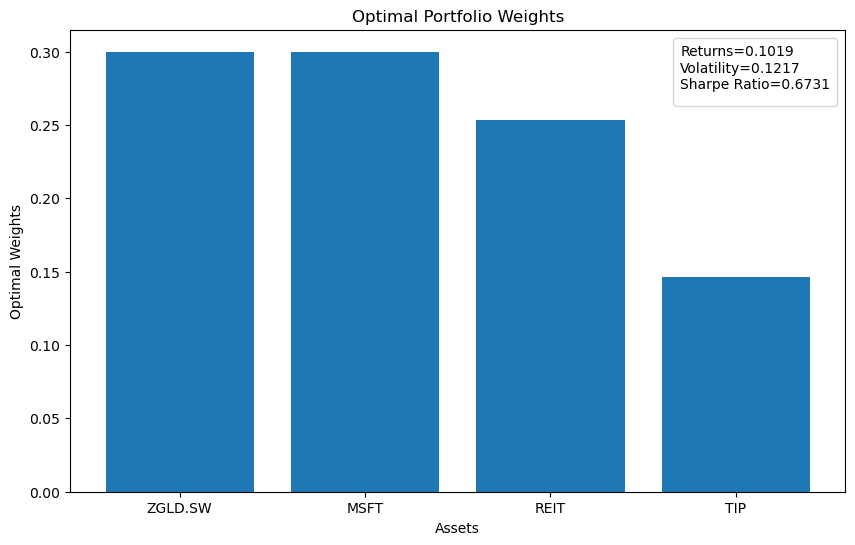

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')
plt.legend(loc='upper right', fontsize='large', title=f'Returns={optimal_portfolio_return:.4f}\n\
Volatility={optimal_portfolio_volatility:.4f}\n\
Sharpe Ratio={optimal_sharpe_ratio:.4f}', title_fontsize='medium')
plt.show()

In [ ]:
Simulate for different weights upper bound and lower bound to see if the return changes
simuklate for different risk free rates to see maximum returns
